<a href="https://colab.research.google.com/github/KKuubaaaC/ML_test/blob/main/Tensorflowmobilenettflite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# === Krok 1: Montowanie Dysku Google ===
from google.colab import drive
drive.mount('/content/drive')

# === Krok 2: Instalacja niezbędnych bibliotek ===
!pip install -q albumentations lxml

# === Krok 3: Importy bibliotek ===
import os
import glob
import xml.etree.ElementTree as ET
import random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
import albumentations as A

# === Krok 4: Sprawdzenie wersji ===
print(f"TensorFlow version: {tf.__version__}")
print(f"Albumentations version: {A.__version__}")

# === Krok 5: Definicja stałych ===
BASE_PATH = '/content/drive/MyDrive/data_5/'
TRAIN_IMG_DIR = os.path.join(BASE_PATH, "train/")
TRAIN_ANN_DIR = os.path.join(BASE_PATH, "train/")
VAL_IMG_DIR = os.path.join(BASE_PATH, "test/")
VAL_ANN_DIR = os.path.join(BASE_PATH, "test/")

# === NOWY KROK: Ścieżka do zapisu modeli na Dysku Google ===
MODEL_SAVE_PATH = os.path.join(BASE_PATH, "models")
os.makedirs(MODEL_SAVE_PATH, exist_ok=True) # Tworzy folder /models, jeśli nie istnieje
print(f"Modele będą zapisywane w: {MODEL_SAVE_PATH}")

# === Krok 6: Definicja hiperparametrów ===
IMG_SIZE = 224
BATCH_SIZE = 8
EPOCHS = 50

print("\nSekcja 1 zakończona pomyślnie: Środowisko skonfigurowane, stałe zdefiniowane.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TensorFlow version: 2.19.0
Albumentations version: 2.0.8
Modele będą zapisywane w: /content/drive/MyDrive/data_5/models

Sekcja 1 zakończona pomyślnie: Środowisko skonfigurowane, stałe zdefiniowane.


In [ ]:
# === Funkcja do parsowania plików XML w formacie Pascal VOC ===
def voc_to_df(img_dir, ann_dir):
    """
    Parsuje pliki XML w formacie Pascal VOC i tworzy z nich pandas DataFrame.
    """
    records = []
    # Używamy glob do znalezienia wszystkich pasujących plików
    xml_paths = sorted(glob.glob(os.path.join(ann_dir, "*.xml")))

    for xml_path in xml_paths:
        try:
            tree = ET.parse(xml_path)
            root = tree.getroot()

            file_name = root.find("filename").text
            img_path = os.path.join(img_dir, file_name)

            # Sprawdzamy, czy obraz faktycznie istnieje, zanim dodamy rekord
            if not os.path.exists(img_path):
                print(f"Ostrzeżenie: Plik obrazu {file_name} nie został znaleziony dla adnotacji {os.path.basename(xml_path)}")
                continue

            size_node = root.find("size")
            w = int(size_node.find("width").text)
            h = int(size_node.find("height").text)

            # Iterujemy po wszystkich obiektach w pliku XML
            for obj in root.findall("object"):
                b = obj.find("bndbox")
                records.append({
                    "file_name": file_name,
                    "full_path": img_path,
                    "width": w,
                    "height": h,
                    "class_name": obj.find("name").text,
                    "xmin": int(b.find("xmin").text),
                    "ymin": int(b.find("ymin").text),
                    "xmax": int(b.find("xmax").text),
                    "ymax": int(b.find("ymax").text),
                })
        except Exception as e:
            print(f"Błąd podczas parsowania pliku {xml_path}: {e}")

    return pd.DataFrame(records)

# === Wczytywanie danych ===
train_df = voc_to_df(TRAIN_IMG_DIR, TRAIN_ANN_DIR)
val_df = voc_to_df(VAL_IMG_DIR, VAL_ANN_DIR)

# === Weryfikacja ===
print(f"\nZnaleziono {len(train_df)} adnotacji w zbiorze treningowym.")
print(f"Znaleziono {len(val_df)} adnotacji w zbiorze walidacyjnym.")

print("\nPierwsze 5 rekordów treningowych:")
display(train_df.head())

print("\nSekcja 2 zakończona pomyślnie: Dane wczytane do DataFrame'ów.")


Znaleziono 40 adnotacji w zbiorze treningowym.
Znaleziono 10 adnotacji w zbiorze walidacyjnym.

Pierwsze 5 rekordów treningowych:


,file_name,full_path,width,height,class_name,xmin,ymin,xmax,ymax
0,object_img001.jpg,/content/drive/MyDrive/data_5/train/object_img...,640,480,object,73,52,223,161
1,object_img002.jpg,/content/drive/MyDrive/data_5/train/object_img...,640,480,object,267,25,422,139
2,object_img003.jpg,/content/drive/MyDrive/data_5/train/object_img...,640,480,object,250,156,408,272
3,object_img004.jpg,/content/drive/MyDrive/data_5/train/object_img...,640,480,object,263,253,422,373
4,object_img005.jpg,/content/drive/MyDrive/data_5/train/object_img...,640,480,object,106,286,259,405



Sekcja 2 zakończona pomyślnie: Dane wczytane do DataFrame'ów.


Znaleziono 1 klasę/y: {'object': 0}

Wyświetlanie przykładów augmentacji...


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


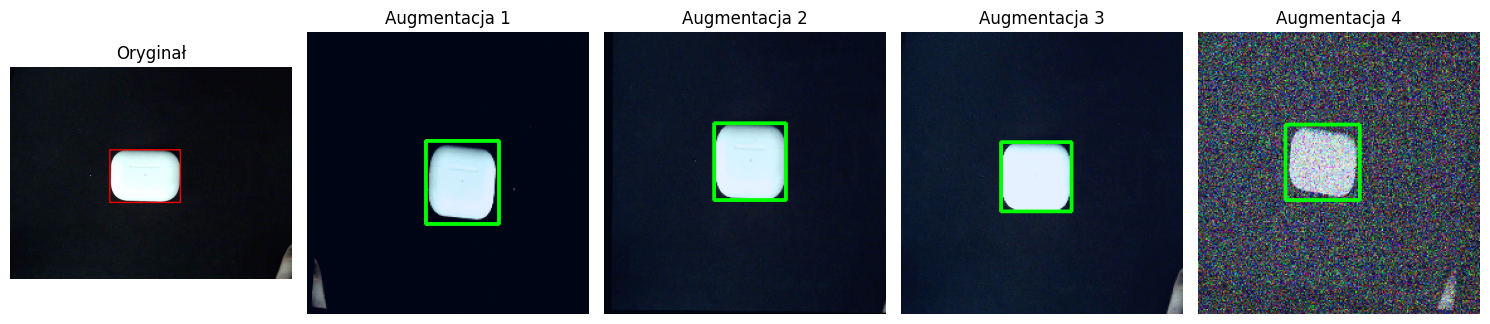


Sekcja 3 zakończona pomyślnie. Sprawdź wizualnie, czy augmentacje i ramki wyglądają poprawnie.


In [ ]:
# === Mapowanie klas na indeksy ===
# Znajdujemy unikalne nazwy klas i tworzymy mapowanie na liczby całkowite
class_names = train_df['class_name'].unique()
class_map = {name: i for i, name in enumerate(class_names)}
num_classes = len(class_names)
print(f"Znaleziono {num_classes} klasę/y: {class_map}")


# === Definicja potoku augmentacji ===
# Używamy bogatego zestawu transformacji, aby walczyć z przeuczeniem.
# 'pascal_voc' to format [xmin, ymin, xmax, ymax].
transform_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.08, scale_limit=0.1, rotate_limit=15, p=0.7),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.7),
    A.GaussNoise(p=0.2),
    # Na końcu ZAWSZE zmiana rozmiaru i normalizacja
    A.Resize(height=IMG_SIZE, width=IMG_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))


# === Funkcja do wizualizacji augmentacji ===
def visualize_augmentations(df, class_map, pipeline, num_samples=4):
    # Wybierz losowy wiersz z DataFrame
    row = df.sample(1).iloc[0]

    # Wczytaj oryginalny obraz
    image = cv2.imread(row['full_path'])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Pobierz oryginalną ramkę
    bbox = [row['xmin'], row['ymin'], row['xmax'], row['ymax']]
    class_label = class_map[row['class_name']]

    # Narysuj oryginalny obraz
    img_copy = image.copy()
    cv2.rectangle(img_copy, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 0, 0), 2)
    plt.figure(figsize=(15, 15))
    plt.subplot(1, num_samples + 1, 1)
    plt.imshow(img_copy)
    plt.title("Oryginał")
    plt.axis('off')

    # Wygeneruj i narysuj augmentowane próbki
    for i in range(num_samples):
        augmented = pipeline(image=image, bboxes=[bbox], class_labels=[class_label])
        aug_img = augmented['image']

        # Denormalizacja do wizualizacji
        vis_img = (aug_img - aug_img.min()) / (aug_img.max() - aug_img.min())

        if augmented['bboxes']: # Sprawdź, czy ramka nie zniknęła
            aug_bbox = augmented['bboxes'][0]
            xmin, ymin, xmax, ymax = [int(v) for v in aug_bbox]
            cv2.rectangle(vis_img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

        plt.subplot(1, num_samples + 1, i + 2)
        plt.imshow(vis_img)
        plt.title(f"Augmentacja {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# === Uruchomienie wizualizacji ===
print("\nWyświetlanie przykładów augmentacji...")
visualize_augmentations(train_df, class_map, transform_pipeline)
print("\nSekcja 3 zakończona pomyślnie. Sprawdź wizualnie, czy augmentacje i ramki wyglądają poprawnie.")

In [ ]:
def create_generator(df, class_map, pipeline, is_training):
    """
    Tworzy generator Pythona, który w locie przetwarza dane i zwraca je
    w formacie odpowiednim dla TensorFlow.
    """
    def generator():
        dff = df.copy()
        while True:
            if is_training:
                dff = dff.sample(frac=1).reset_index(drop=True)

            for _, row in dff.iterrows():
                image = cv2.imread(row['full_path'])
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                bbox = [row['xmin'], row['ymin'], row['xmax'], row['ymax']]
                class_id = class_map[row['class_name']]

                augmented = pipeline(image=image, bboxes=[bbox], class_labels=[class_id])
                aug_img = augmented['image']

                if not augmented['bboxes']:
                    continue

                aug_bbox = augmented['bboxes'][0]
                # Normalizuj współrzędne ramki do zakresu [0, 1] - kluczowe dla regresji
                # Format: [ymin, xmin, ymax, xmax]
                norm_bbox = [
                    aug_bbox[1] / IMG_SIZE, # ymin
                    aug_bbox[0] / IMG_SIZE, # xmin
                    aug_bbox[3] / IMG_SIZE, # ymax
                    aug_bbox[2] / IMG_SIZE  # xmax
                ]

                # Zwróć dane we właściwym formacie dla model.fit
                yield aug_img, (float(class_id), tf.constant(norm_bbox, dtype=tf.float32))

    return generator

# --- Definicja potoku walidacyjnego (bez augmentacji, tylko resize i normalizacja) ---
val_pipeline = A.Compose([
    A.Resize(height=IMG_SIZE, width=IMG_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))


# --- Tworzenie generatorów ---
train_generator = create_generator(train_df, class_map, transform_pipeline, is_training=True)
val_generator = create_generator(val_df, class_map, val_pipeline, is_training=False)


# --- Tworzenie obiektów tf.data.Dataset ---
# Musimy zdefiniować strukturę wyjściową naszego generatora
output_signature = (
    tf.TensorSpec(shape=(IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
    (
        tf.TensorSpec(shape=(), dtype=tf.float32),
        tf.TensorSpec(shape=(4,), dtype=tf.float32)
    )
)

train_dataset = tf.data.Dataset.from_generator(train_generator, output_signature=output_signature)
val_dataset = tf.data.Dataset.from_generator(val_generator, output_signature=output_signature)

# --- Optymalizacja potoków ---
# Zmieniamy format wyjściowy, aby pasował do nazw wyjść modelu
def format_output(image, labels):
    class_label, box_label = labels
    return image, {"classes": class_label, "boxes": box_label}

train_dataset = train_dataset.map(format_output, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(format_output, num_parallel_calls=tf.data.AUTOTUNE)

# Batchowanie i prefetching
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Struktura wyjściowa potoku danych:")
print(train_dataset.element_spec)
print("\nSekcja 4 zakończona pomyślnie: Utworzono potoki danych dla treningu i walidacji.")

Struktura wyjściowa potoku danych:
(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), {'classes': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'boxes': TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)})

Sekcja 4 zakończona pomyślnie: Utworzono potoki danych dla treningu i walidacji.


In [ ]:
def create_model(num_classes):
    """
    Tworzy model detekcji obiektów oparty na MobileNetV2.
    """
    # --- Szkielet (Backbone) ---
    backbone = tf.keras.applications.MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False, # Nie potrzebujemy głowicy klasyfikacyjnej z ImageNet
        weights='imagenet'
    )
    # Zamrażamy wagi szkieletu - kluczowe dla transfer learning
    backbone.trainable = False

    # --- Wejście modelu ---
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # --- Przekazanie danych przez szkielet ---
    x = backbone(inputs, training=False)

    # --- Wspólna podstawa dla głowic ---
    # Dodajemy kilka warstw konwolucyjnych, aby model nauczył się cech specyficznych dla naszego zadania
    x = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)

    # --- Głowica regresji (Bounding Box Head) ---
    # Ta głowica ma za zadanie precyzyjnie zlokalizować obiekt
    bh = layers.Flatten()(x)
    bh = layers.Dense(128, activation="relu")(bh)
    bh = layers.Dense(64, activation="relu")(bh)
    # Wyjście ma 4 neurony (ymin, xmin, ymax, xmax) i aktywację sigmoid,
    # ponieważ normalizowaliśmy współrzędne do zakresu [0, 1].
    box_output = layers.Dense(4, activation='sigmoid', name='boxes')(bh)

    # --- Głowica klasyfikacji (Class Head) ---
    # Ta głowica decyduje, CZY na obrazie jest obiekt
    ch = layers.GlobalAveragePooling2D()(x)
    ch = layers.Dense(64, activation="relu")(ch)
    # Wyjście ma 1 neuron (dla jednej klasy) z aktywacją sigmoid
    class_output = layers.Dense(num_classes, activation='sigmoid', name='classes')(ch)

    # Zwracamy model, podając wejście i słownik wyjść, aby pasował do naszego tf.data.Dataset
    model = Model(inputs=inputs, outputs={"classes": class_output, "boxes": box_output})

    return model

# --- Tworzenie i kompilacja ---
model = create_model(num_classes)

# Kompilujemy model, definiując funkcje straty dla każdego z wyjść
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss={
        "classes": tf.keras.losses.BinaryCrossentropy(),
        "boxes": tf.keras.losses.MeanSquaredError()
    },
    loss_weights={ # Kładziemy większy nacisk na stratę z lokalizacji ramki
        "classes": 1.0,
        "boxes": 2.0
    }
)

print("Podsumowanie modelu:")
model.summary()
print("\nSekcja 5 zakończona pomyślnie: Model został zbudowany i skompilowany.")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Podsumowanie modelu:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 7, 7,      │  2,257,984 │ input_layer_1[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 7, 7, 128) │  1,474,688 │ mobilenetv2_1.00… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 7, 7, 128) │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 6272)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    802,944 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ boxes (Dense)       │ (None, 4)         │        260 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classes (Dense)     │ (None, 1)         │         65 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,552,965 (17.37 MB)

 Trainable params: 2,294,725 (8.75 MB)

 Non-trainable params: 2,258,240 (8.61 MB)


Sekcja 5 zakończona pomyślnie: Model został zbudowany i skompilowany.


In [ ]:
# === Sekcja 6: Definicja Callbacków ===

# Ścieżka do pliku modelu na Dysku Google
best_model_path = os.path.join(MODEL_SAVE_PATH, "best_model.h5")

# Callback do zapisywania najlepszej wersji modelu
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=best_model_path,  # ZAKTUALIZOWANA ŚCIEŻKA
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Callback do wczesnego zatrzymywania treningu
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Callback do dynamicznej zmiany szybkości uczenia
reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

callbacks = [checkpoint_cb, early_stopping_cb, reduce_lr_cb]
print(f"Sekcja 6 zakończona pomyślnie: Zdefiniowano callbacki. Najlepszy model zostanie zapisany jako '{best_model_path}'.")

# === Sekcja 7: Trening Modelu ===

steps_per_epoch = len(train_df) // BATCH_SIZE
validation_steps = len(val_df) // BATCH_SIZE

print(f"\nRozpoczynanie treningu na {EPOCHS} epok...")

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

print("\nSekcja 7 zakończona pomyślnie: Trening modelu (faza 1) został ukończony.")

Sekcja 6 zakończona pomyślnie: Zdefiniowano callbacki. Najlepszy model zostanie zapisany jako '/content/drive/MyDrive/data_5/models/best_model.h5'.

Rozpoczynanie treningu na 50 epok...
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - boxes_loss: 0.0024 - classes_loss: 0.0813 - loss: 0.0861
Epoch 1: val_loss improved from inf to 0.02727, saving model to /content/drive/MyDrive/data_5/models/best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 908ms/step - boxes_loss: 0.0024 - classes_loss: 0.0800 - loss: 0.0849 - val_boxes_loss: 0.0026 - val_classes_loss: 0.0221 - val_loss: 0.0273 - learning_rate: 2.5000e-05
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - boxes_loss: 0.0046 - classes_loss: 0.1199 - loss: 0.1290
Epoch 2: val_loss did not improve from 0.02727
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 555ms/step - boxes_loss: 0.0044 - classes_loss: 0.1196 - loss: 0.1284 - val_boxes_loss: 0.0025 - val_classes_loss: 0.0235 - val_loss: 0.0285 - learning_rate: 2.5000e-05
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - boxes_loss: 0.0028 - classes_loss: 0.0542 - loss: 0.0597
Epoch 3: val_loss improved from 0.02727 to 0.02698, saving model to /content/drive/MyDrive/data_5/models/best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 692ms/step - boxes_loss: 0.0028 - classes_loss: 0.0566 - loss: 0.0622 - val_boxes_loss: 0.0025 - val_classes_loss: 0.0219 - val_loss: 0.0270 - learning_rate: 2.5000e-05
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - boxes_loss: 0.0024 - classes_loss: 0.0412 - loss: 0.0461
Epoch 4: val_loss improved from 0.02698 to 0.02690, saving model to /content/drive/MyDrive/data_5/models/best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - boxes_loss: 0.0024 - classes_loss: 0.0425 - loss: 0.0473 - val_boxes_loss: 0.0023 - val_classes_loss: 0.0222 - val_loss: 0.0269 - learning_rate: 2.5000e-05
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - boxes_loss: 0.0024 - classes_loss: 0.0333 - loss: 0.0382
Epoch 5: val_loss improved from 0.02690 to 0.02592, saving model to /content/drive/MyDrive/data_5/models/best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - boxes_loss: 0.0025 - classes_loss: 0.0347 - loss: 0.0397 - val_boxes_loss: 0.0022 - val_classes_loss: 0.0215 - val_loss: 0.0259 - learning_rate: 2.5000e-05
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - boxes_loss: 0.0028 - classes_loss: 0.0612 - loss: 0.0668
Epoch 6: val_loss improved from 0.02592 to 0.02482, saving model to /content/drive/MyDrive/data_5/models/best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - boxes_loss: 0.0030 - classes_loss: 0.0611 - loss: 0.0670 - val_boxes_loss: 0.0021 - val_classes_loss: 0.0206 - val_loss: 0.0248 - learning_rate: 2.5000e-05
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 719ms/step - boxes_loss: 0.0023 - classes_loss: 0.0363 - loss: 0.0410
Epoch 7: val_loss did not improve from 0.02482
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 968ms/step - boxes_loss: 0.0024 - classes_loss: 0.0372 - loss: 0.0421 - val_boxes_loss: 0.0021 - val_classes_loss: 0.0214 - val_loss: 0.0256 - learning_rate: 2.5000e-05
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - boxes_loss: 0.0026 - classes_loss: 0.0295 - loss: 0.0347
Epoch 8: val_loss did not improve from 0.02482
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 564ms/step - boxes_loss: 0.0026 - classes_loss: 0.0309 - loss: 0.0360 - val_boxes_loss: 0.0021 - val_classes_loss: 0.0220 - val_loss: 0.0263 - learning_rate: 2.5000e-05
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - boxes_loss: 0.0040 - classes_loss: 0.0532 - loss

5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - boxes_loss: 0.0021 - classes_loss: 0.0524 - loss: 0.0565 - val_boxes_loss: 0.0023 - val_classes_loss: 0.0196 - val_loss: 0.0242 - learning_rate: 2.5000e-05
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - boxes_loss: 0.0032 - classes_loss: 0.0234 - loss: 0.0298
Epoch 12: val_loss improved from 0.02419 to 0.02386, saving model to /content/drive/MyDrive/data_5/models/best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 816ms/step - boxes_loss: 0.0032 - classes_loss: 0.0250 - loss: 0.0313 - val_boxes_loss: 0.0023 - val_classes_loss: 0.0192 - val_loss: 0.0239 - learning_rate: 2.5000e-05
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - boxes_loss: 0.0030 - classes_loss: 0.0289 - loss: 0.0349
Epoch 13: val_loss did not improve from 0.02386
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 559ms/step - boxes_loss: 0.0030 - classes_loss: 0.0309 - loss: 0.0368 - val_boxes_loss: 0.0023 - val_classes_loss: 0.0196 - val_loss: 0.0242 - learning_rate: 2.5000e-05
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 712ms/step - boxes_loss: 0.0028 - classes_loss: 0.0310 - loss: 0.0366
Epoch 14: val_loss improved from 0.02386 to 0.02378, saving model to /content/drive/MyDrive/data_5/models/best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - boxes_loss: 0.0029 - classes_loss: 0.0318 - loss: 0.0375 - val_boxes_loss: 0.0022 - val_classes_loss: 0.0194 - val_loss: 0.0238 - learning_rate: 2.5000e-05
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - boxes_loss: 0.0026 - classes_loss: 0.0296 - loss: 0.0348
Epoch 15: val_loss improved from 0.02378 to 0.02277, saving model to /content/drive/MyDrive/data_5/models/best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 678ms/step - boxes_loss: 0.0026 - classes_loss: 0.0301 - loss: 0.0353 - val_boxes_loss: 0.0020 - val_classes_loss: 0.0188 - val_loss: 0.0228 - learning_rate: 2.5000e-05
Epoch 16/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - boxes_loss: 0.0025 - classes_loss: 0.0271 - loss: 0.0320
Epoch 16: val_loss improved from 0.02277 to 0.02183, saving model to /content/drive/MyDrive/data_5/models/best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 686ms/step - boxes_loss: 0.0025 - classes_loss: 0.0274 - loss: 0.0324 - val_boxes_loss: 0.0019 - val_classes_loss: 0.0180 - val_loss: 0.0218 - learning_rate: 2.5000e-05
Epoch 17/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 754ms/step - boxes_loss: 0.0028 - classes_loss: 0.0409 - loss: 0.0465
Epoch 17: val_loss improved from 0.02183 to 0.02111, saving model to /content/drive/MyDrive/data_5/models/best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - boxes_loss: 0.0028 - classes_loss: 0.0417 - loss: 0.0474 - val_boxes_loss: 0.0019 - val_classes_loss: 0.0174 - val_loss: 0.0211 - learning_rate: 2.5000e-05
Epoch 18/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - boxes_loss: 0.0028 - classes_loss: 0.0476 - loss: 0.0532
Epoch 18: val_loss did not improve from 0.02111
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 588ms/step - boxes_loss: 0.0027 - classes_loss: 0.0482 - loss: 0.0537 - val_boxes_loss: 0.0018 - val_classes_loss: 0.0181 - val_loss: 0.0218 - learning_rate: 2.5000e-05
Epoch 19/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - boxes_loss: 0.0025 - classes_loss: 0.0784 - loss: 0.0835
Epoch 19: val_loss did not improve from 0.02111
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 562ms/step - boxes_loss: 0.0025 - classes_loss: 0.0748 - loss: 0.0797 - val_boxes_loss: 0.0019 - val_classes_loss: 0.0174 - val_loss: 0.0212 - learning_rate: 2.5000e-05
Epoch 20/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - boxes_loss: 0.0027 - classes_loss: 0.0419 -

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 903ms/step - boxes_loss: 0.0027 - classes_loss: 0.0415 - loss: 0.0469 - val_boxes_loss: 0.0019 - val_classes_loss: 0.0172 - val_loss: 0.0211 - learning_rate: 2.5000e-05
Epoch 21/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - boxes_loss: 0.0030 - classes_loss: 0.0362 - loss: 0.0421
Epoch 21: val_loss improved from 0.02107 to 0.02039, saving model to /content/drive/MyDrive/data_5/models/best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 929ms/step - boxes_loss: 0.0029 - classes_loss: 0.0359 - loss: 0.0417 - val_boxes_loss: 0.0020 - val_classes_loss: 0.0164 - val_loss: 0.0204 - learning_rate: 2.5000e-05
Epoch 22/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - boxes_loss: 0.0032 - classes_loss: 0.0326 - loss: 0.0391
Epoch 22: val_loss improved from 0.02039 to 0.02004, saving model to /content/drive/MyDrive/data_5/models/best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - boxes_loss: 0.0032 - classes_loss: 0.0327 - loss: 0.0390 - val_boxes_loss: 0.0020 - val_classes_loss: 0.0161 - val_loss: 0.0200 - learning_rate: 2.5000e-05
Epoch 23/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - boxes_loss: 0.0023 - classes_loss: 0.0375 - loss: 0.0420
Epoch 23: val_loss did not improve from 0.02004
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - boxes_loss: 0.0023 - classes_loss: 0.0373 - loss: 0.0418 - val_boxes_loss: 0.0019 - val_classes_loss: 0.0163 - val_loss: 0.0202 - learning_rate: 2.5000e-05
Epoch 24/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - boxes_loss: 0.0023 - classes_loss: 0.0315 - loss: 0.0361
Epoch 24: val_loss improved from 0.02004 to 0.02004, saving model to /content/drive/MyDrive/data_5/models/best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - boxes_loss: 0.0023 - classes_loss: 0.0308 - loss: 0.0354 - val_boxes_loss: 0.0021 - val_classes_loss: 0.0159 - val_loss: 0.0200 - learning_rate: 2.5000e-05
Epoch 25/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - boxes_loss: 0.0039 - classes_loss: 0.0678 - loss: 0.0756
Epoch 25: val_loss improved from 0.02004 to 0.02001, saving model to /content/drive/MyDrive/data_5/models/best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 688ms/step - boxes_loss: 0.0039 - classes_loss: 0.0666 - loss: 0.0743 - val_boxes_loss: 0.0021 - val_classes_loss: 0.0159 - val_loss: 0.0200 - learning_rate: 2.5000e-05
Epoch 26/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - boxes_loss: 0.0033 - classes_loss: 0.0827 - loss: 0.0893
Epoch 26: val_loss did not improve from 0.02001
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - boxes_loss: 0.0032 - classes_loss: 0.0807 - loss: 0.0872 - val_boxes_loss: 0.0021 - val_classes_loss: 0.0163 - val_loss: 0.0205 - learning_rate: 2.5000e-05
Epoch 27/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - boxes_loss: 0.0025 - classes_loss: 0.0290 - loss: 0.0339
Epoch 27: val_loss improved from 0.02001 to 0.01994, saving model to /content/drive/MyDrive/data_5/models/best_model.h5



Epoch 27: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - boxes_loss: 0.0026 - classes_loss: 0.0317 - loss: 0.0368 - val_boxes_loss: 0.0021 - val_classes_loss: 0.0158 - val_loss: 0.0199 - learning_rate: 2.5000e-05
Epoch 28/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - boxes_loss: 0.0026 - classes_loss: 0.0413 - loss: 0.0465
Epoch 28: val_loss did not improve from 0.01994
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 973ms/step - boxes_loss: 0.0026 - classes_loss: 0.0425 - loss: 0.0477 - val_boxes_loss: 0.0020 - val_classes_loss: 0.0159 - val_loss: 0.0200 - learning_rate: 1.2500e-05
Epoch 29/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - boxes_loss: 0.0019 - classes_loss: 0.0246 - loss: 0.0284
Epoch 29: val_loss did not improve from 0.01994
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - boxes_loss: 0.0019 - classes_loss: 0.0260 - loss: 0.0299 - val_boxes_loss: 0.0021 - val_classes_loss: 0.0160 - val_loss: 0.0201 - learning_rate: 1.2500e-05
Epoch 30/50
5/5 ━━━━━

5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - boxes_loss: 0.0030 - classes_loss: 0.0280 - loss: 0.0340 - val_boxes_loss: 0.0022 - val_classes_loss: 0.0154 - val_loss: 0.0197 - learning_rate: 6.2500e-06
Epoch 34/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - boxes_loss: 0.0028 - classes_loss: 0.0811 - loss: 0.0867
Epoch 34: val_loss did not improve from 0.01975
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 731ms/step - boxes_loss: 0.0028 - classes_loss: 0.0817 - loss: 0.0874 - val_boxes_loss: 0.0021 - val_classes_loss: 0.0163 - val_loss: 0.0205 - learning_rate: 6.2500e-06
Epoch 35/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - boxes_loss: 0.0028 - classes_loss: 0.0318 - loss: 0.0375
Epoch 35: val_loss did not improve from 0.01975
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 558ms/step - boxes_loss: 0.0028 - classes_loss: 0.0346 - loss: 0.0402 - val_boxes_loss: 0.0021 - val_classes_loss: 0.0161 - val_loss: 0.0203 - learning_rate: 6.2500e-06
Epoch 36/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - boxes_loss: 0.0026 - classes_loss: 0.0477 -

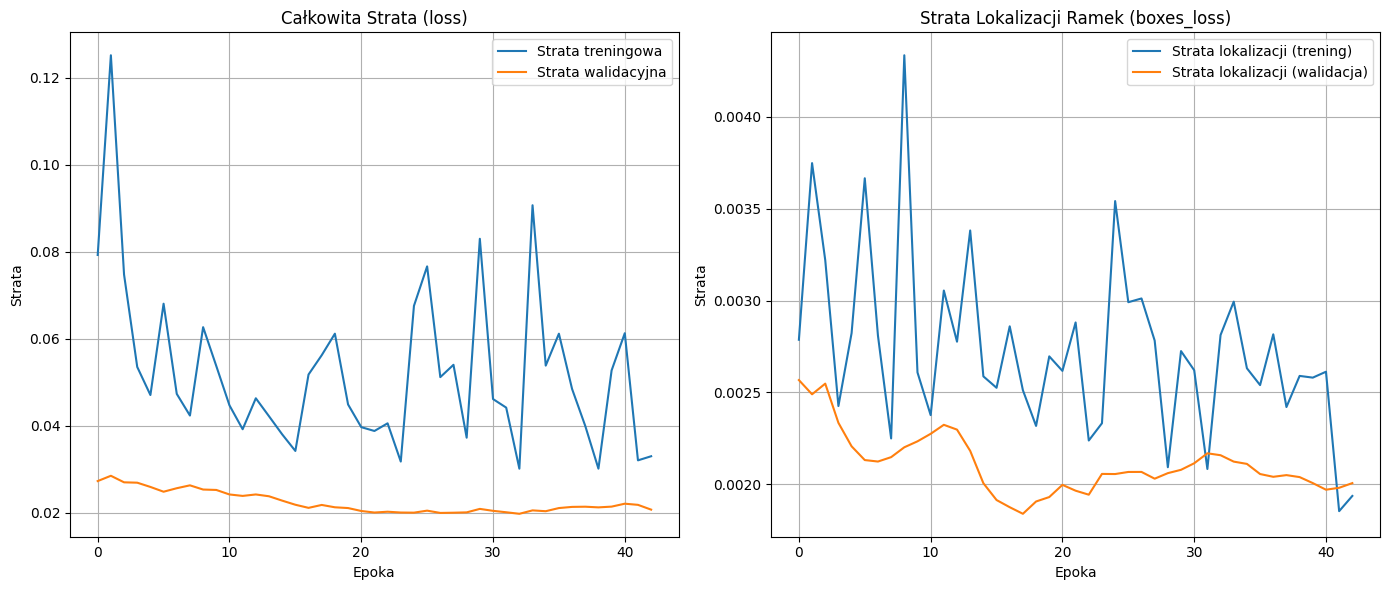


Wyświetlanie losowej predykcji ze zbioru walidacyjnego...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


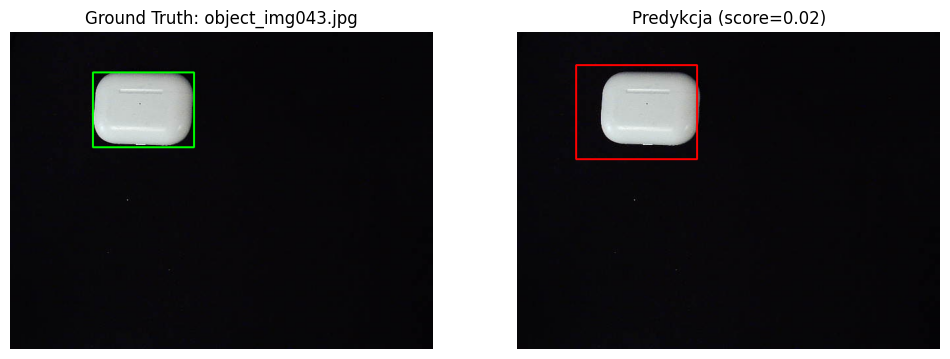

In [ ]:
# ... (kod do rysowania wykresów pozostaje bez zmian) ...
# Wykresy historii treningu
history_df = pd.DataFrame(history.history)
plt.figure(figsize=(14, 6))

# Wykres całkowitej straty
plt.subplot(1, 2, 1)
plt.plot(history_df['loss'], label='Strata treningowa')
plt.plot(history_df['val_loss'], label='Strata walidacyjna')
plt.title('Całkowita Strata (loss)')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.legend()
plt.grid(True)

# Wykres straty lokalizacji (boxes)
plt.subplot(1, 2, 2)
plt.plot(history_df['boxes_loss'], label='Strata lokalizacji (trening)')
plt.plot(history_df['val_boxes_loss'], label='Strata lokalizacji (walidacja)')
plt.title('Strata Lokalizacji Ramek (boxes_loss)')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# === Funkcja do wizualizacji predykcji (bez zmian w logice, ale teraz ścieżka będzie poprawna) ===
def predict_and_visualize(df, model_path):
    # Wczytaj najlepszy model (ten, który zapisał ModelCheckpoint)
    best_model = tf.keras.models.load_model(model_path, compile=False)

    # Wybierz losowy wiersz z podanego DataFrame
    row = df.sample(1).iloc[0]

    # Wczytaj oryginalny obraz
    orig_img = cv2.imread(row['full_path'])
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    H, W, _ = orig_img.shape

    # Przygotuj obraz do predykcji (tylko resize i normalizacja)
    processed = val_pipeline(image=orig_img, bboxes=[[0,0,1,1]], class_labels=[0])
    input_tensor = processed['image'][None, ...] # Dodaj wymiar batcha

    # Dokonaj predykcji
    pred = best_model.predict(input_tensor)
    pred_cls = pred['classes'][0][0]
    pred_box = pred['boxes'][0] # [ymin, xmin, ymax, xmax]

    # Przetwórz współrzędne do rysowania
    gt_xmin, gt_ymin, gt_xmax, gt_ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
    pred_ymin = int(pred_box[0] * H)
    pred_xmin = int(pred_box[1] * W)
    pred_ymax = int(pred_box[2] * H)
    pred_xmax = int(pred_box[3] * W)

    # Rysowanie
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    gt_img = orig_img.copy()
    cv2.rectangle(gt_img, (gt_xmin, gt_ymin), (gt_xmax, gt_ymax), (0, 255, 0), 2)
    axes[0].imshow(gt_img)
    axes[0].set_title(f"Ground Truth: {row['file_name']}")
    pred_img = orig_img.copy()
    cv2.rectangle(pred_img, (pred_xmin, pred_ymin), (pred_xmax, pred_ymax), (255, 0, 0), 2)
    axes[1].imshow(pred_img)
    axes[1].set_title(f"Predykcja (score={pred_cls:.2f})")

    for ax in axes:
        ax.axis('off')
    plt.show()

# === Uruchomienie wizualizacji na zbiorze walidacyjnym ===
# ZAKTUALIZOWANA ŚCIEŻKA do modelu
best_model_path = os.path.join(MODEL_SAVE_PATH, "best_model.h5")
print("\nWyświetlanie losowej predykcji ze zbioru walidacyjnego...")
predict_and_visualize(val_df, best_model_path)

Wczytywanie najlepszego modelu z Dysku Google...
Szkielet 'mobilenetv2_1.00_224' został odmrożony.
Kompilowanie modelu do etapu Fine-Tuning...

Rozpoczynanie etapu Fine-Tuning na 30 epok...
Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - boxes_loss: 0.0284 - classes_loss: 0.5427 - loss: 0.5994
Epoch 1: val_loss improved from inf to 0.01680, saving model to /content/drive/MyDrive/data_5/models/fine_tuned_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - boxes_loss: 0.0286 - classes_loss: 0.5346 - loss: 0.5918 - val_boxes_loss: 0.0023 - val_classes_loss: 0.0121 - val_loss: 0.0168 - learning_rate: 1.0000e-05
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - boxes_loss: 0.0285 - classes_loss: 0.4724 - loss: 0.5295
Epoch 2: val_loss improved from 0.01680 to 0.01502, saving model to /content/drive/MyDrive/data_5/models/fine_tuned_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - boxes_loss: 0.0281 - classes_loss: 0.4721 - loss: 0.5284 - val_boxes_loss: 0.0026 - val_classes_loss: 0.0099 - val_loss: 0.0150 - learning_rate: 1.0000e-05
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - boxes_loss: 0.0217 - classes_loss: 0.3689 - loss: 0.4123
Epoch 3: val_loss improved from 0.01502 to 0.01369, saving model to /content/drive/MyDrive/data_5/models/fine_tuned_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - boxes_loss: 0.0213 - classes_loss: 0.3680 - loss: 0.4107 - val_boxes_loss: 0.0028 - val_classes_loss: 0.0080 - val_loss: 0.0137 - learning_rate: 1.0000e-05
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - boxes_loss: 0.0195 - classes_loss: 0.3487 - loss: 0.3876
Epoch 4: val_loss improved from 0.01369 to 0.01245, saving model to /content/drive/MyDrive/data_5/models/fine_tuned_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - boxes_loss: 0.0196 - classes_loss: 0.3496 - loss: 0.3888 - val_boxes_loss: 0.0030 - val_classes_loss: 0.0064 - val_loss: 0.0124 - learning_rate: 1.0000e-05
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - boxes_loss: 0.0200 - classes_loss: 0.3721 - loss: 0.4121
Epoch 5: val_loss improved from 0.01245 to 0.01170, saving model to /content/drive/MyDrive/data_5/models/fine_tuned_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - boxes_loss: 0.0198 - classes_loss: 0.3675 - loss: 0.4071 - val_boxes_loss: 0.0033 - val_classes_loss: 0.0052 - val_loss: 0.0117 - learning_rate: 1.0000e-05
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - boxes_loss: 0.0207 - classes_loss: 0.3218 - loss: 0.3632
Epoch 6: val_loss improved from 0.01170 to 0.01144, saving model to /content/drive/MyDrive/data_5/models/fine_tuned_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - boxes_loss: 0.0205 - classes_loss: 0.3269 - loss: 0.3680 - val_boxes_loss: 0.0036 - val_classes_loss: 0.0043 - val_loss: 0.0114 - learning_rate: 1.0000e-05
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - boxes_loss: 0.0235 - classes_loss: 0.3133 - loss: 0.3603
Epoch 7: val_loss improved from 0.01144 to 0.01140, saving model to /content/drive/MyDrive/data_5/models/fine_tuned_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - boxes_loss: 0.0239 - classes_loss: 0.3131 - loss: 0.3609 - val_boxes_loss: 0.0039 - val_classes_loss: 0.0036 - val_loss: 0.0114 - learning_rate: 1.0000e-05
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - boxes_loss: 0.0235 - classes_loss: 0.3372 - loss: 0.3842
Epoch 8: val_loss did not improve from 0.01140
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - boxes_loss: 0.0235 - classes_loss: 0.3323 - loss: 0.3793 - val_boxes_loss: 0.0043 - val_classes_loss: 0.0030 - val_loss: 0.0116 - learning_rate: 1.0000e-05
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - boxes_loss: 0.0163 - classes_loss: 0.3046 - loss: 0.3372
Epoch 9: val_loss did not improve from 0.01140
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - boxes_loss: 0.0163 - classes_loss: 0.3021 - loss: 0.3347 - val_boxes_loss: 0.0047 - val_classes_loss: 0.0026 - val_loss: 0.0120 - learning_rate: 1.0000e-05
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - boxes_loss: 0.0182 - classes_loss: 0.2833 - loss: 0.3197
Ep

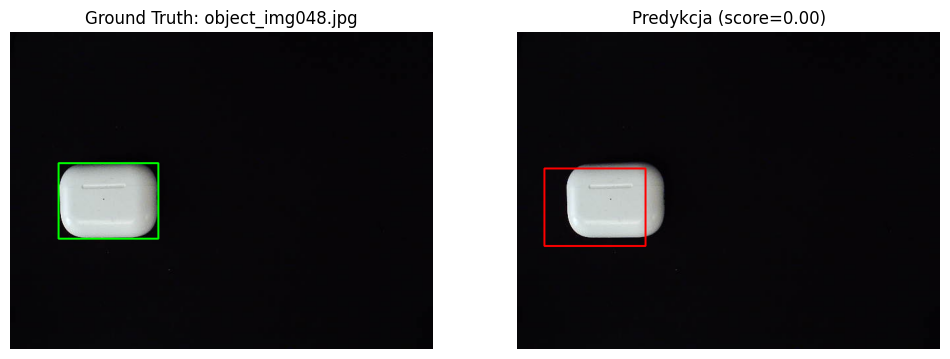

In [ ]:
# Ścieżki do modeli
best_model_path = os.path.join(MODEL_SAVE_PATH, "best_model.h5")
fine_tuned_model_path = os.path.join(MODEL_SAVE_PATH, "fine_tuned_model.h5")

# === Krok 1: Wczytanie najlepszego modelu z poprzedniego etapu ===
print("Wczytywanie najlepszego modelu z Dysku Google...")
model_to_tune = tf.keras.models.load_model(best_model_path, compile=False) # ZAKTUALIZOWANA ŚCIEŻKA

# === Krok 2: Odmrożenie szkieletu ===
try:
    backbone = model_to_tune.get_layer('mobilenetv2_1.00_224')
    backbone.trainable = True
    print("Szkielet 'mobilenetv2_1.00_224' został odmrożony.")
except ValueError:
    print("Nie znaleziono domyślnej nazwy warstwy. Próbuję znaleźć po nazwie częściowej...")
    for layer in model_to_tune.layers:
        if 'mobilenet' in layer.name:
            layer.trainable = True
            print(f"Odmrożono warstwę: {layer.name}")
            break

# === Krok 3: Rekompilacja modelu z BARDZO niską szybkością uczenia ===
print("Kompilowanie modelu do etapu Fine-Tuning...")
model_to_tune.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss={"classes": tf.keras.losses.BinaryCrossentropy(), "boxes": tf.keras.losses.MeanSquaredError()},
    loss_weights={"classes": 1.0, "boxes": 2.0}
)

# === Krok 4: Definicja nowych callbacków i kontynuacja treningu ===
EPOCHS_FINE_TUNE = 30

checkpoint_ft_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=fine_tuned_model_path, # ZAKTUALIZOWANA ŚCIEŻKA
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

callbacks_ft = [checkpoint_ft_cb, early_stopping_cb, reduce_lr_cb]

print(f"\nRozpoczynanie etapu Fine-Tuning na {EPOCHS_FINE_TUNE} epok...")
history_ft = model_to_tune.fit(
    train_dataset,
    epochs=EPOCHS_FINE_TUNE,
    validation_data=val_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks_ft
)

print("\nSekcja 9 zakończona pomyślnie: Fine-tuning modelu został ukończony.")

# === Ostateczna wizualizacja po fine-tuningu ===
print("\nWyświetlanie losowej predykcji z modelu po fine-tuningu...")
predict_and_visualize(val_df, fine_tuned_model_path) # ZAKTUALIZOWANA ŚCIEŻKA

Wczytywanie ostatecznego modelu z: /content/drive/MyDrive/data_5/models/fine_tuned_model.h5
Model wczytany pomyślnie.

--- Wyświetlanie 10 losowych predykcji ---


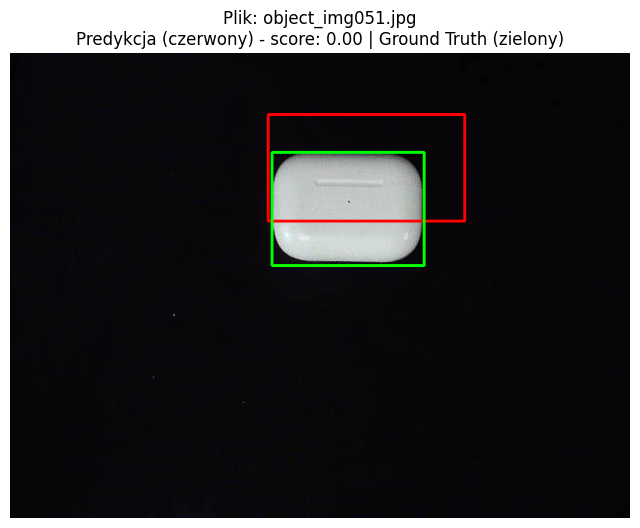

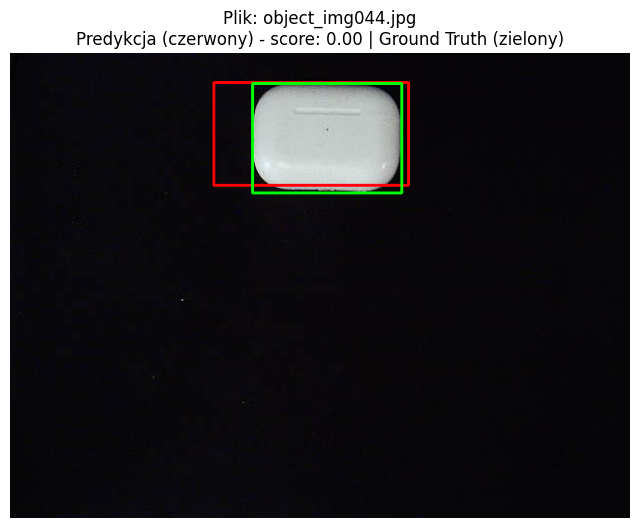

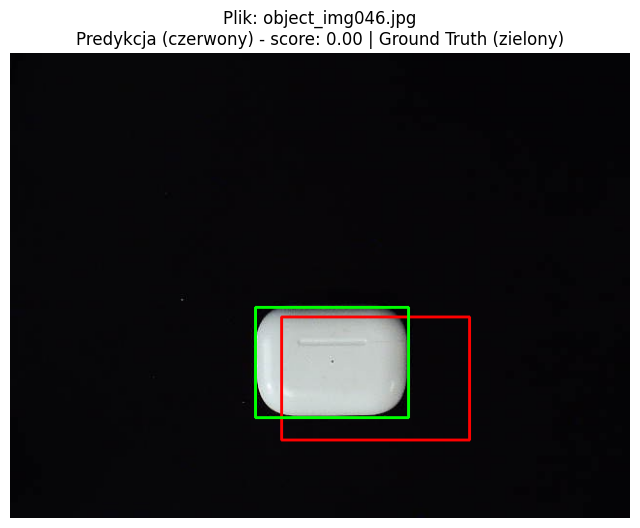

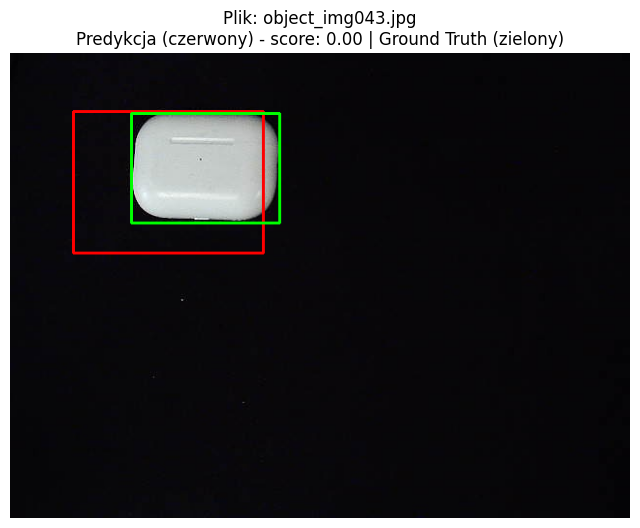

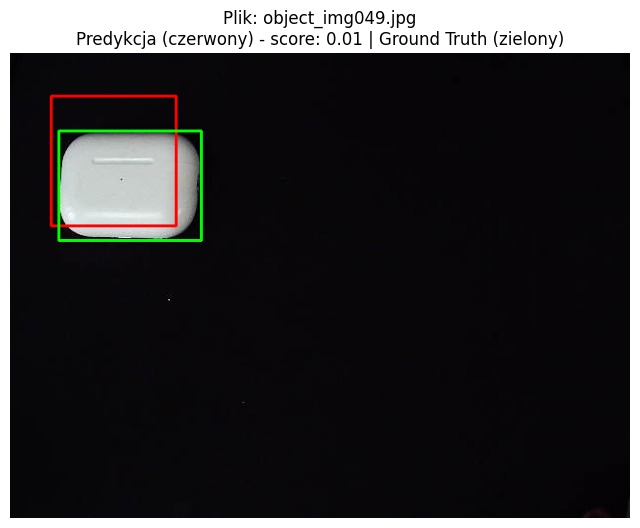

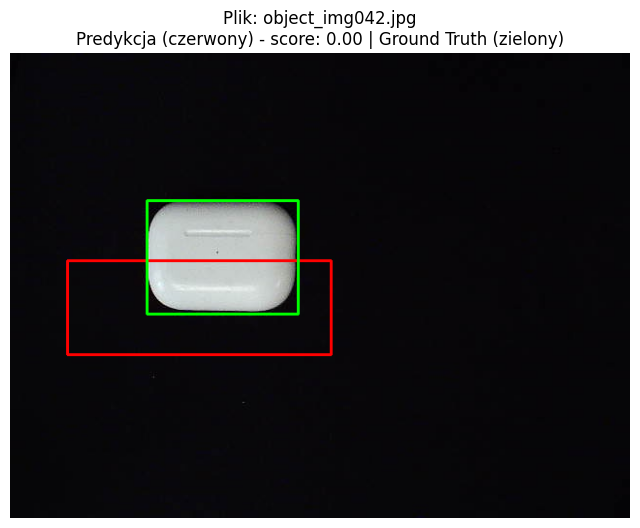

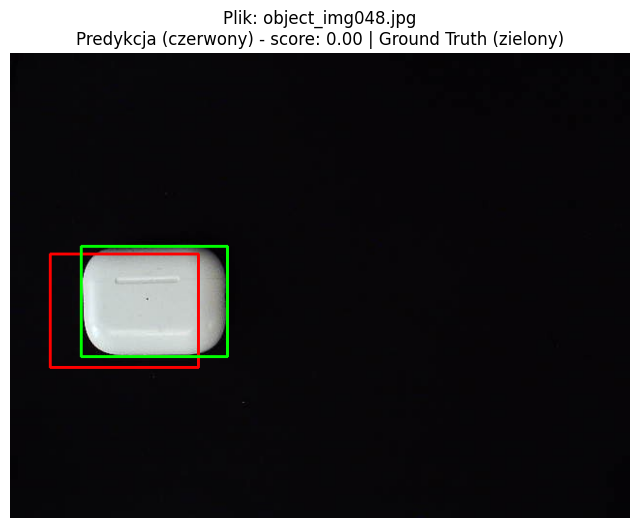

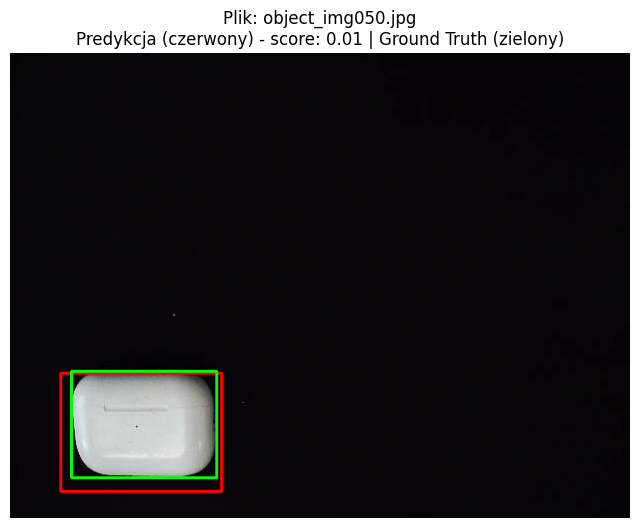

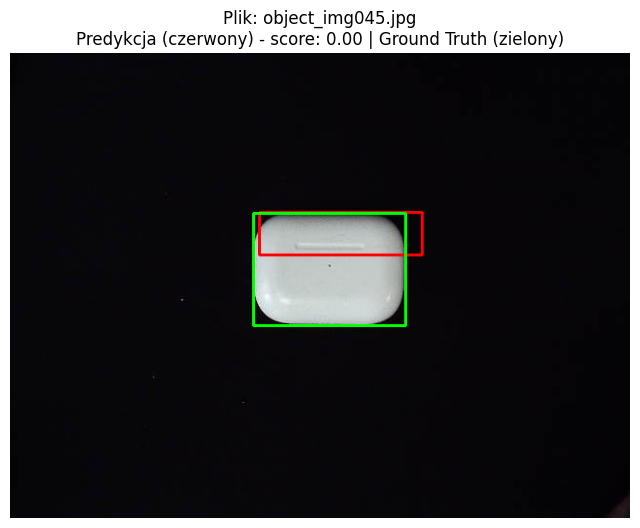

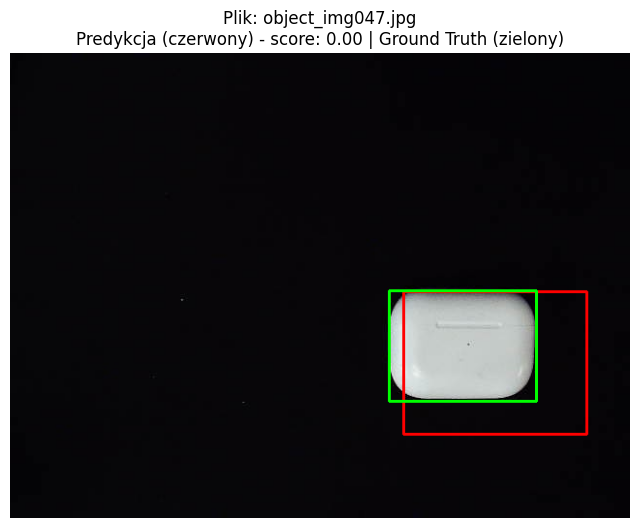

In [ ]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

# === Krok 1: Zdefiniowanie ścieżek i wczytanie ostatecznego modelu ===
# Upewnij się, że zmienna MODEL_SAVE_PATH jest zdefiniowana (powinna być z Sekcji 1)
fine_tuned_model_path = os.path.join(MODEL_SAVE_PATH, "fine_tuned_model.h5")

print(f"Wczytywanie ostatecznego modelu z: {fine_tuned_model_path}")
# Wczytujemy model raz, aby nie robić tego w pętli.
# compile=False przyspiesza wczytywanie, bo nie potrzebujemy optymalizatora do predykcji.
final_model = tf.keras.models.load_model(fine_tuned_model_path, compile=False)
print("Model wczytany pomyślnie.")


# === Krok 2: Funkcja do wyświetlania pojedynczej predykcji ===
# Ta funkcja bierze wiersz danych, model i przetwarza jeden obraz.
def display_prediction(row, model, pipeline):
    # Wczytaj oryginalny obraz
    image = cv2.imread(row['full_path'])
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    H, W, _ = image_rgb.shape

    # Przygotuj obraz do predykcji (używamy tego samego potoku co dla walidacji)
    processed = pipeline(image=image_rgb, bboxes=[[0,0,1,1]], class_labels=[0])
    input_tensor = processed['image'][None, ...] # Dodaj wymiar batcha

    # Dokonaj predykcji
    pred = model.predict(input_tensor, verbose=0) # verbose=0 wycisza logi predykcji
    pred_cls_score = pred['classes'][0][0]
    pred_box = pred['boxes'][0] # format [ymin, xmin, ymax, xmax]

    # Odnormalizuj współrzędne ramki
    pred_ymin = int(pred_box[0] * H)
    pred_xmin = int(pred_box[1] * W)
    pred_ymax = int(pred_box[2] * H)
    pred_xmax = int(pred_box[3] * W)

    # Narysuj ramkę predykcji (czerwona)
    cv2.rectangle(image_rgb, (pred_xmin, pred_ymin), (pred_xmax, pred_ymax), (255, 0, 0), 2)
    # Narysuj ramkę ground truth (zielona) dla porównania
    gt_xmin, gt_ymin, gt_xmax, gt_ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
    cv2.rectangle(image_rgb, (gt_xmin, gt_ymin), (gt_xmax, gt_ymax), (0, 255, 0), 2)


    # Wyświetl obraz
    plt.figure(figsize=(8, 8))
    plt.imshow(image_rgb)
    plt.title(f"Plik: {row['file_name']}\nPredykcja (czerwony) - score: {pred_cls_score:.2f} | Ground Truth (zielony)")
    plt.axis('off')
    plt.show()


# === Krok 3: Wybór 10 losowych obrazów i uruchomienie wizualizacji ===
# val_df powinien być dostępny z Sekcji 2
if 'val_df' in globals():
    num_predictions_to_show = 10
    print(f"\n--- Wyświetlanie {num_predictions_to_show} losowych predykcji ---")

    # Wybieramy 10 losowych próbek ze zbioru walidacyjnego
    sample_images = val_df.sample(num_predictions_to_show)

    # Iterujemy po wybranych próbkach i wyświetlamy predykcje
    for index, row in sample_images.iterrows():
        display_prediction(row, final_model, val_pipeline)
else:
    print("BŁĄD: DataFrame 'val_df' nie został znaleziony. Uruchom najpierw Sekcję 2.")

In [ ]:
import tensorflow as tf
import os
import numpy as np

# === Krok 1: Zdefiniowanie ścieżek i wczytanie modelu Keras ===
# Upewnij się, że ścieżka do zapisu modeli jest zdefiniowana
# Powinna pochodzić z Sekcji 1 i wskazywać na folder na Twoim Dysku Google.
if 'MODEL_SAVE_PATH' not in globals():
    print("BŁĄD: Zmienna MODEL_SAVE_PATH nie jest zdefiniowana. Uruchom Sekcję 1.")
else:
    # Ścieżka do modelu wejściowego (po fine-tuningu)
    keras_model_path = os.path.join(MODEL_SAVE_PATH, "fine_tuned_model.h5")

    # Ścieżka do zapisu modelu TFLite
    tflite_model_path = os.path.join(MODEL_SAVE_PATH, "final_model.tflite")

    print(f"Wczytywanie modelu Keras z: {keras_model_path}")
    model = tf.keras.models.load_model(keras_model_path)
    print("Model Keras wczytany pomyślnie.")


Wczytywanie modelu Keras z: /content/drive/MyDrive/data_5/models/fine_tuned_model.h5


Model Keras wczytany pomyślnie.


IndentationError: unexpected indent (ipython-input-3465432063.py, line 4)

In [ ]:
import tensorflow as tf
import os
import numpy as np

# === Krok 1: Zdefiniowanie ścieżek i wczytanie modelu Keras ===
# Upewnij się, że ścieżka do zapisu modeli jest zdefiniowana
# Powinna pochodzić z Sekcji 1 i wskazywać na folder na Twoim Dysku Google.
if 'MODEL_SAVE_PATH' not in globals():
    print("BŁĄD: Zmienna MODEL_SAVE_PATH nie jest zdefiniowana. Uruchom Sekcję 1.")
else:
    # Ścieżka do modelu wejściowego (po fine-tuningu)
    keras_model_path = os.path.join(MODEL_SAVE_PATH, "fine_tuned_model.h5")

    # Ścieżka do zapisu modelu TFLite
    tflite_model_path = os.path.join(MODEL_SAVE_PATH, "final_model.tflite")

    print(f"Wczytywanie modelu Keras z: {keras_model_path}")
    model = tf.keras.models.load_model(keras_model_path)
    print("Model Keras wczytany pomyślnie.")

    # === Krok 2: Konwersja do TensorFlow Lite ===

    # Inicjalizacja konwertera
    converter = tf.lite.TFLiteConverter.from_keras_model(model)

    # --- WYBIERZ JEDNĄ Z PONIŻSZYCH OPCJI KONWERSJI ---

    # Opcja 1: Konwersja standardowa (bez optymalizacji)
    # Najprostsza forma, zachowuje wagi jako 32-bitowe liczby zmiennoprzecinkowe.
    # converter.optimizations = []

    # Opcja 2: Optymalizacja z kwantyzacją dynamicznego zakresu (ZALECANE JAKO PIERWSZY KROK)
    # Zmniejsza rozmiar modelu ~4x poprzez kwantyzację wag do 8-bitowych liczb całkowitych.
    # Jest to świetny kompromis między rozmiarem a prostotą użycia.
    converter.optimizations = [tf.lite.Optimize.DEFAULT]

    # Opcja 3: Pełna kwantyzacja na liczby całkowite (NAJBARDZIEJ WYDAJNA)
    # Wymaga "reprezentatywnego zbioru danych", aby skalibrować wagi i aktywacje.
    # Daje najmniejszy model i najszybszą inferencję na wspieranym sprzęcie (np. CPU, Edge TPU).
    # Aby użyć tej opcji, odkomentuj poniższy blok.
    """
    def representative_dataset_gen():
        # Używamy ~100-200 próbek z danych walidacyjnych
        for image_batch, _ in val_dataset.take(100):
            yield [image_batch]

    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_dataset_gen
    # Wymuś, aby wejścia i wyjścia również były w formacie całkowitoliczbowym
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.int8  # lub tf.uint8
    converter.inference_output_type = tf.int8 # lub tf.uint8
    """

    # Przeprowadzenie konwersji
    tflite_model = converter.convert()

    # === Krok 3: Zapisanie przekonwertowanego modelu na dysku ===
    with open(tflite_model_path, 'wb') as f:
        f.write(tflite_model)

    print(f"\nModel został pomyślnie przekonwertowany i zapisany w: {tflite_model_path}")

    # Porównanie rozmiarów plików
    keras_size = os.path.getsize(keras_model_path) / (1024 * 1024)
    tflite_size = os.path.getsize(tflite_model_path) / (1024 * 1024)
    print(f"Rozmiar oryginalnego modelu Keras: {keras_size:.2f} MB")
    print(f"Rozmiar przekonwertowanego modelu TFLite: {tflite_size:.2f} MB")
    print(f"Redukcja rozmiaru: {keras_size / tflite_size:.1f}x")


    # === Krok 4: Weryfikacja modelu TFLite ===
    print("\n--- Weryfikacja modelu TFLite ---")

    # Wczytaj losowy obraz do testu
    row = val_df.sample(1).iloc[0]
    image = cv2.imread(row['full_path'])
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Przygotuj obraz wejściowy (ten sam preprocessing co w treningu)
    processed = val_pipeline(image=image_rgb, bboxes=[[0,0,1,1]], class_labels=[0])
    input_data = processed['image'][None, ...] # Dodaj wymiar batcha

    # Załaduj model TFLite do interpretera
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()

    # Pobierz szczegóły wejścia i wyjścia
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Ustaw tensor wejściowy
    interpreter.set_tensor(input_details[0]['index'], np.array(input_data, dtype=np.float32))

    # Uruchom inferencję
    interpreter.invoke()

    # Pobierz wyniki. Twój model ma dwa wyjścia, więc interpreter zwróci je w kolejności.
    # Zakładamy, że pierwsze wyjście to 'boxes', a drugie 'classes' (kolejność może zależeć od budowy modelu)
    # Możesz zweryfikować nazwy i kolejność w `output_details`
    # print(output_details)

    # Wyjście 1: Zazwyczaj to, co jest pierwsze w liście 'outputs' w definicji modelu
    output_1 = interpreter.get_tensor(output_details[0]['index'])
    # Wyjście 2:
    output_2 = interpreter.get_tensor(output_details[1]['index'])

    # Sprawdź, które wyjście ma kształt (1, 4) dla ramki, a które (1, 1) dla klasy
    if output_1.shape == (1, 4):
        pred_box_tflite = output_1[0]
        pred_cls_tflite = output_2[0][0]
    else:
        pred_box_tflite = output_2[0]
        pred_cls_tflite = output_1[0][0]

    print(f"Predykcja z modelu TFLite na obrazie '{row['file_name']}':")
    print(f"  - Score klasy: {pred_cls_tflite:.4f}")
    print(f"  - Współrzędne ramki [ymin, xmin, ymax, xmax]: {np.round(pred_box_tflite, 4)}")
    print("\nWygląda na to, że model TFLite działa poprawnie!")

Wczytywanie modelu Keras z: /content/drive/MyDrive/data_5/models/fine_tuned_model.h5


Model Keras wczytany pomyślnie.
Saved artifact at '/tmp/tmpdiqbi597'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  Dict[['classes', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)], ['boxes', TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)]]
Captures:
  134611612812880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134611612814992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134611612814800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134611612812688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134611612816336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134611612814032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134611612815184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134611612811920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134611612814416: TensorSpec(shape

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


Ładowanie modelu z: /content/drive/MyDrive/data_5/models/final_model.tflite
Model oczekuje obrazu wejściowego o wymiarach: 224x224

--- Rozpoczynanie testów na 5 losowych obrazach ---


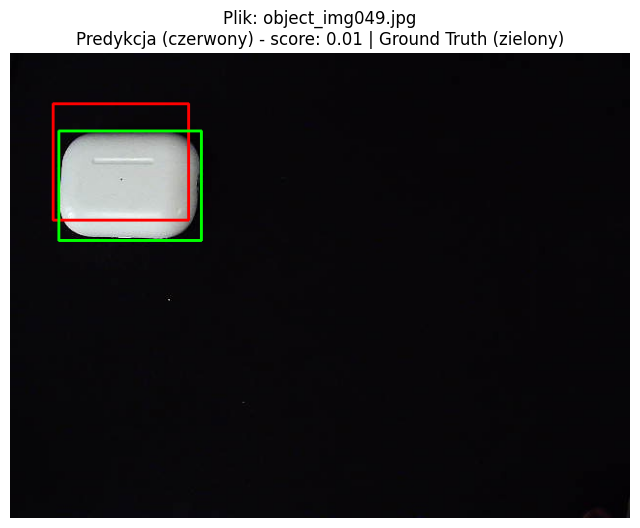

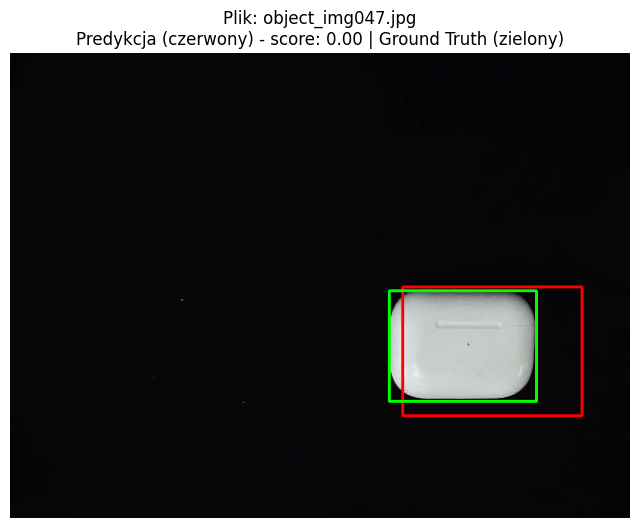

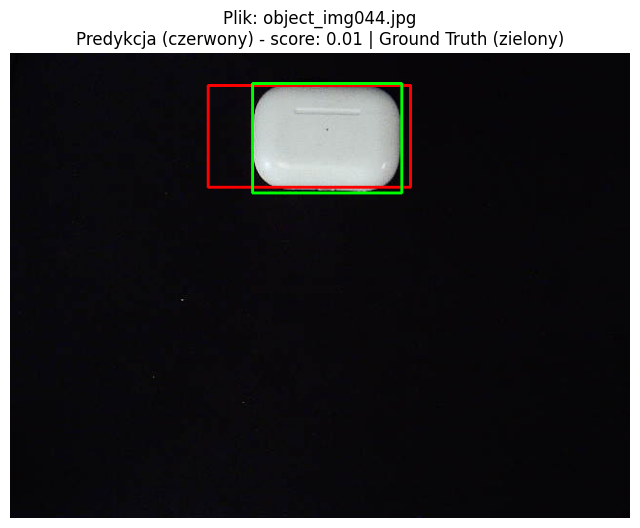

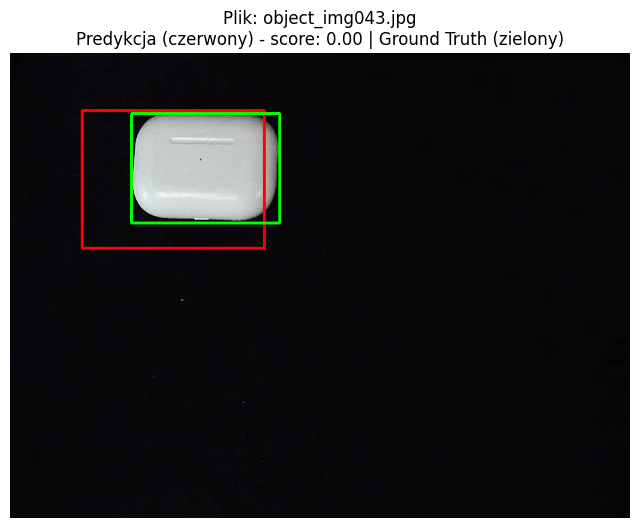

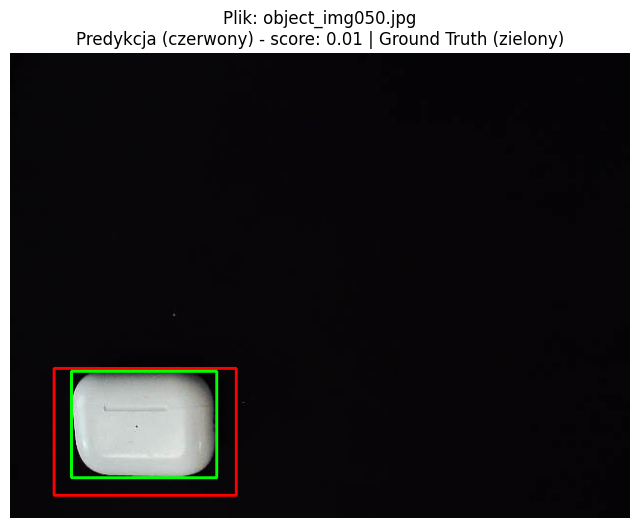

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# === Krok 1: Przygotowanie środowiska ===

# Upewnij się, że zmienne ze ścieżkami i danymi są dostępne
if 'MODEL_SAVE_PATH' not in globals() or 'val_df' not in globals():
    print("BŁĄD: Zmienne 'MODEL_SAVE_PATH' lub 'val_df' nie są zdefiniowane.")
    print("Upewnij się, że uruchomiłeś wcześniejsze sekcje notatnika (szczególnie Sekcję 1 i 2).")
else:
    tflite_model_path = os.path.join(MODEL_SAVE_PATH, "final_model.tflite")

    # === Krok 2: Załadowanie modelu TFLite do interpretera ===
    print(f"Ładowanie modelu z: {tflite_model_path}")
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()

    # Pobranie szczegółów wejścia i wyjścia
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Sprawdzenie kształtu wejściowego
    height = input_details[0]['shape'][1]
    width = input_details[0]['shape'][2]
    print(f"Model oczekuje obrazu wejściowego o wymiarach: {height}x{width}")


    # === Krok 3: Wybranie losowych obrazów do testów ===
    num_images_to_test = 5
    print(f"\n--- Rozpoczynanie testów na {num_images_to_test} losowych obrazach ---")

    sample_images = val_df.sample(num_images_to_test)

    for index, row in sample_images.iterrows():
        # --- a) Wczytanie i przygotowanie obrazu ---
        image_path = row['full_path']
        image_original = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image_original, cv2.COLOR_BGR2RGB)
        H, W, _ = image_rgb.shape # Oryginalne wymiary

        # Używamy tego samego potoku do preprocessingu co przy walidacji
        processed = val_pipeline(image=image_rgb, bboxes=[[0,0,1,1]], class_labels=[0])
        input_data = processed['image'][None, ...] # Dodanie wymiaru batcha

        # --- b) Uruchomienie inferencji TFLite ---
        interpreter.set_tensor(input_details[0]['index'], np.array(input_data, dtype=np.float32))
        interpreter.invoke()

        # --- c) Odczytanie i przetworzenie wyników ---
        # Sprawdzamy, które wyjście jest które, na podstawie kształtu
        output_1 = interpreter.get_tensor(output_details[0]['index'])
        output_2 = interpreter.get_tensor(output_details[1]['index'])

        if output_1.shape == (1, 4):
            pred_box = output_1[0]
            pred_score = output_2[0][0]
        else:
            pred_box = output_2[0]
            pred_score = output_1[0][0]

        # Denormalizacja współrzędnych [ymin, xmin, ymax, xmax]
        pred_ymin = int(pred_box[0] * H)
        pred_xmin = int(pred_box[1] * W)
        pred_ymax = int(pred_box[2] * H)
        pred_xmax = int(pred_box[3] * W)

        # --- d) Wizualizacja ---
        # Kopiujemy oryginalny obraz, aby na nim rysować
        image_with_boxes = image_rgb.copy()

        # Rysujemy ramkę predykcji (czerwona)
        cv2.rectangle(image_with_boxes, (pred_xmin, pred_ymin), (pred_xmax, pred_ymax), (255, 0, 0), 2)

        # Rysujemy ramkę ground truth (zielona) dla porównania
        gt_xmin, gt_ymin, gt_xmax, gt_ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
        cv2.rectangle(image_with_boxes, (gt_xmin, gt_ymin), (gt_xmax, gt_ymax), (0, 255, 0), 2)

        # Wyświetlamy obraz z ramkami
        plt.figure(figsize=(8, 8))
        plt.imshow(image_with_boxes)
        plt.title(f"Plik: {row['file_name']}\nPredykcja (czerwony) - score: {pred_score:.2f} | Ground Truth (zielony)")
        plt.axis('off')
        plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
